In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import division
from __future__ import print_function
import keras as keras
from vizdoom import *
import itertools as it
from random import sample, randint, random
from time import time, sleep
import numpy as np
from keras_sfa import *
import skimage.color, skimage.transform
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from tqdm import trange

# Q-learning settings
learning_rate = 0.00025
# learning_rate = 0.0001
discount_factor = 0.99
epochs = 7
learning_steps_per_epoch = 2000
replay_memory_size = 10000

# NN learning settings
batch_size = 64

# SFA learning settings
sfa_batch_size = 6400 #4*batch_size
W = np.zeros((sfa_batch_size, sfa_batch_size))

for i in range(sfa_batch_size):
    for j in range(sfa_batch_size):
        if abs(i-j) < 2 and i<j and i%2 is 0 and j%2 is 1:
            W[i, j] = 1
            W[j, i] = 1

# Training regime
test_episodes_per_epoch = 1

# Other parameters
frame_repeat = 12
resolution = (30, 45)
episodes_to_watch = 20

model_savefile = "/tmp/model.ckpt"
save_model = True
load_model = False
skip_learning = False
# Configuration file path
config_file_path = "../../scenarios/simpler_basic.cfg"
#config_file_path = "../../scenarios/health_gathering.cfg"
#config_file_path = "../../scenarios/deadly_corridor.cfg"
#config_file_path = "../../scenarios/rocket_basic.cfg"
#config_file_path = "../../scenarios/basic.cfg"

In [2]:
# Converts and down-samples the input image
def preprocess(img):
    img = skimage.transform.resize(img, resolution)
    img = img.astype(np.float32)
    return img


class ReplayMemory:
    def __init__(self, capacity):
        channels = 1
        state_shape = (capacity, resolution[0], resolution[1], channels)
        self.s1 = np.zeros(state_shape, dtype=np.float32)
        self.s2 = np.zeros(state_shape, dtype=np.float32)
        self.a = np.zeros(capacity, dtype=np.int32)
        self.r = np.zeros(capacity, dtype=np.float32)
        self.isterminal = np.zeros(capacity, dtype=np.float32)

        self.capacity = capacity
        self.size = 0
        self.pos = 0

    def add_transition(self, s1, action, s2, isterminal, reward):
        self.s1[self.pos, :, :, 0] = s1
        self.a[self.pos] = action
        if not isterminal:
            self.s2[self.pos, :, :, 0] = s2
        self.isterminal[self.pos] = isterminal
        self.r[self.pos] = reward

        self.pos = (self.pos + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def get_sample(self, sample_size):
        i = sample(range(0, self.size), sample_size)
        return self.s1[i], self.a[i], self.s2[i], self.isterminal[i], self.r[i]


def create_network(session, available_actions_count):
    # Create the input variables
    s1_ = tf.placeholder(tf.float32, [None] + list(resolution) + [1], name="State")
    a_ = tf.placeholder(tf.int32, [None], name="Action")
    target_q_ = tf.placeholder(tf.float32, [None, available_actions_count], name="TargetQ")

    # Add 2 convolutional layers with ReLu activation
    conv1 = tf.contrib.layers.convolution2d(s1_, num_outputs=8, kernel_size=[6, 6], stride=[3, 3],
                                            activation_fn=tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                            biases_initializer=tf.constant_initializer(0.1))
    conv2 = tf.contrib.layers.convolution2d(conv1, num_outputs=8, kernel_size=[3, 3], stride=[2, 2],
                                            activation_fn=tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                            biases_initializer=tf.constant_initializer(0.1))
    conv2_flat = tf.contrib.layers.flatten(conv2)
    fc1 = tf.contrib.layers.fully_connected(conv2_flat, num_outputs=128, activation_fn=tf.nn.relu,
                                            weights_initializer=tf.contrib.layers.xavier_initializer(),
                                            biases_initializer=tf.constant_initializer(0.1))

    q = tf.contrib.layers.fully_connected(fc1, num_outputs=available_actions_count, activation_fn=None,
                                          weights_initializer=tf.contrib.layers.xavier_initializer(),
                                          biases_initializer=tf.constant_initializer(0.1))
    best_a = tf.argmax(q, 1)

    loss = tf.losses.mean_squared_error(q, target_q_)

    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    # Update the parameters according to the computed gradient using RMSProp.
    train_step = optimizer.minimize(loss)

    def function_learn(s1, target_q):
        feed_dict = {s1_: s1, target_q_: target_q}
        l, _ = session.run([loss, train_step], feed_dict=feed_dict)
        return l

    def function_get_q_values(state):
        return session.run(q, feed_dict={s1_: state})

    def function_get_best_action(state):
        return session.run(best_a, feed_dict={s1_: state})

    def function_simple_get_best_action(state):
        return function_get_best_action(state.reshape([1, resolution[0], resolution[1], 1]))[0]

    return function_learn, function_get_q_values, function_simple_get_best_action


def learn_from_memory():
    """ Learns from a single transition (making use of replay memory).
    s2 is ignored if s2_isterminal """

    # Get a random minibatch from the replay memory and learns from it.
    if memory.size > batch_size:
        s1, a, s2, isterminal, r = memory.get_sample(batch_size)

        q2 = np.max(get_q_values(s2), axis=1)
        target_q = get_q_values(s1)
        # target differs from q only for the selected action. The following means:
        # target_Q(s,a) = r + gamma * max Q(s2,_) if isterminal else r
        target_q[np.arange(target_q.shape[0]), a] = r + discount_factor * (1 - isterminal) * q2
        learn(s1, target_q)


def perform_learning_step(epoch):
    """ Makes an action according to eps-greedy policy, observes the result
    (next state, reward) and learns from the transition"""

    def exploration_rate(epoch):
        """# Define exploration rate change over time"""
        start_eps = 1.0
        end_eps = 0.1
        const_eps_epochs = 0.1 * epochs  # 10% of learning time
        eps_decay_epochs = 0.6 * epochs  # 60% of learning time

        if epoch < const_eps_epochs:
            return start_eps
        elif epoch < eps_decay_epochs:
            # Linear decay
            return start_eps - (epoch - const_eps_epochs) / \
                               (eps_decay_epochs - const_eps_epochs) * (start_eps - end_eps)
        else:
            return end_eps

    s1 = preprocess(game.get_state().screen_buffer)

    # With probability eps make a random action.
    eps = exploration_rate(epoch)
    if random() <= eps:
        a = randint(0, len(actions) - 1)
    else:
        # Choose the best action according to the network.
        a = get_best_action(s1)
    reward = game.make_action(actions[a], frame_repeat)

    isterminal = game.is_episode_finished()
    s2 = preprocess(game.get_state().screen_buffer) if not isterminal else None

    # Remember the transition that was just experienced.
    memory.add_transition(s1, a, s2, isterminal, reward)

    learn_from_memory()


# Creates and initializes ViZDoom environment.
def initialize_vizdoom(config_file_path):
    print("Initializing doom...")
    game = DoomGame()
    game.load_config(config_file_path)
    game.set_window_visible(False)
    game.set_mode(Mode.PLAYER)
    game.set_screen_format(ScreenFormat.GRAY8)
    game.set_screen_resolution(ScreenResolution.RES_640X480)
    game.init()
    print("Doom initialized.")
    return game

def get_sfa_batch_from_memory(batch_size, memory):
    s1, a, s2, isterminal, r = memory.get_sample(batch_size*3)
    riffled = np.zeros((sfa_batch_size, s1.shape[1], s1.shape[2], s1.shape[3]))
    not_terminal_indices =  [i for i in range(len(isterminal)) if isterminal[i] == 0]
    
    for j in range(int(sfa_batch_size/2)):        
        riffled[j*2, :, :, :] = s1[not_terminal_indices[j], :, :, :]
        riffled[j*2+1, :, :, :]= s2[not_terminal_indices[j], :, :, :]
    return riffled #s1, a, s2, isterminal, r


In [3]:


if __name__ == '__main__':
    # Create Doom instance
    game = initialize_vizdoom(config_file_path)

    # Action = which buttons are pressed
    n = game.get_available_buttons_size()
    actions = [list(a) for a in it.product([0, 1], repeat=n)]

    # Create replay memory which will store the transitions
    memory = ReplayMemory(capacity=replay_memory_size)

    session = tf.Session()
    learn, get_q_values, get_best_action = create_network(session, len(actions))
    
    saver = tf.train.Saver()
    if load_model:
        print("Loading model from: ", model_savefile)
        saver.restore(session, model_savefile)
    else:
        init = tf.global_variables_initializer()
        session.run(init)
    print("Starting the training!")
    
    # "Manually" adapt learning rate
    epoch = 0
    def step_decay(keras_epoch):
        return (epochs-epoch) * 0.002 / float(epoch)
    lrate = LearningRateScheduler(step_decay)
    

    time_start = time()
    net = sfa_vizdoom_default_cnn(resolution[0], resolution[1], 7) #general_sfa_net(resolution[0], resolution[1])
    if not skip_learning:
        for epoch in range(epochs):
            print("\nEpoch %d\n-------" % (epoch + 1))
            train_episodes_finished = 0
            train_scores = []

            print("Training...")
            game.new_episode()
            for learning_step in trange(learning_steps_per_epoch, leave=False):
                perform_learning_step(epoch)
                #if epoch > 0 and memory.size > sfa_batch_size and learning_step % 500 is 0:
                    #data = get_sfa_batch_from_memory(int(sfa_batch_size/2), memory)
                    #net.fit(data, W, batch_size=sfa_batch_size, epochs=1, shuffle=False, verbose = 1,
                    #        callbacks=[lrate])
                if game.is_episode_finished():
                    score = game.get_total_reward()
                    train_scores.append(score)
                    game.new_episode()
                    train_episodes_finished += 1

            print("%d training episodes played." % train_episodes_finished)

            train_scores = np.array(train_scores)

            print("Results: mean: %.1f±%.1f," % (train_scores.mean(), train_scores.std()), \
                  "min: %.1f," % train_scores.min(), "max: %.1f," % train_scores.max())

            print("\nTesting...")
            test_episode = []
            test_scores = []
            for test_episode in trange(test_episodes_per_epoch, leave=False):
                game.new_episode()
                while not game.is_episode_finished():
                    state = preprocess(game.get_state().screen_buffer)
                    best_action_index = get_best_action(state)

                    game.make_action(actions[best_action_index], frame_repeat)
                r = game.get_total_reward()
                test_scores.append(r)

            test_scores = np.array(test_scores)
            print("Results: mean: %.1f±%.1f," % (
                test_scores.mean(), test_scores.std()), "min: %.1f" % test_scores.min(),
                  "max: %.1f" % test_scores.max())

            print("Saving the network weights to:", model_savefile)
            saver.save(session, model_savefile)

            print("Total elapsed time: %.2f minutes" % ((time() - time_start) / 60.0))

    game.close()
    print("======================================")
    print("Training finished. It's time to watch!")

    # Reinitialize the game with window visible
    game.set_window_visible(True)
    game.set_mode(Mode.ASYNC_PLAYER)
    game.init()

    for _ in range(episodes_to_watch):
        game.new_episode()
        while not game.is_episode_finished():
            state = preprocess(game.get_state().screen_buffer)
            best_action_index = get_best_action(state)

            # Instead of make_action(a, frame_repeat) in order to make the animation smooth
            game.set_action(actions[best_action_index])
            for _ in range(frame_repeat):
                game.advance_action()

        # Sleep between episodes
        sleep(1.0)
        score = game.get_total_reward()
        print("Total score: ", score)


Initializing doom...
Doom initialized.
Starting the training!


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:621: UserWarning: Class `keras_sfa.PowerWhitening` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  0%|          | 7/2000 [00:00<00:28, 69.43it/s]

(?, 7)

Epoch 1
-------
Training...


  0%|          | 0/1 [00:00<?, ?it/s]

128 training episodes played.
Results: mean: -155.7±177.7, min: -375.0, max: 95.0,

Testing...


  0%|          | 3/2000 [00:00<01:11, 28.02it/s]

Results: mean: -410.0±0.0, min: -410.0 max: -410.0
Saving the network weights to: /tmp/model.ckpt
Total elapsed time: 7.00 minutes

Epoch 2
-------
Training...


  0%|          | 0/2000 [00:00<?, ?it/s]

154 training episodes played.
Results: mean: -107.7±181.3, min: -395.0, max: 95.0,

Testing...
Results: mean: 57.0±0.0, min: 57.0 max: 57.0
Saving the network weights to: /tmp/model.ckpt
Total elapsed time: 8.46 minutes

Epoch 3
-------
Training...


  0%|          | 0/2000 [00:00<?, ?it/s]

187 training episodes played.
Results: mean: -76.6±182.6, min: -395.0, max: 95.0,

Testing...
Results: mean: 83.0±0.0, min: 83.0 max: 83.0
Saving the network weights to: /tmp/model.ckpt
Total elapsed time: 10.11 minutes

Epoch 4
-------
Training...


  0%|          | 0/2000 [00:00<?, ?it/s]

417 training episodes played.
Results: mean: 36.2±79.1, min: -375.0, max: 95.0,

Testing...
Results: mean: 95.0±0.0, min: 95.0 max: 95.0
Saving the network weights to: /tmp/model.ckpt
Total elapsed time: 11.82 minutes

Epoch 5
-------
Training...


  0%|          | 0/2000 [00:00<?, ?it/s]

649 training episodes played.
Results: mean: 64.2±27.5, min: -113.0, max: 95.0,

Testing...
Results: mean: 71.0±0.0, min: 71.0 max: 71.0
Saving the network weights to: /tmp/model.ckpt
Total elapsed time: 13.87 minutes

Epoch 6
-------
Training...


  0%|          | 0/2000 [00:00<?, ?it/s]

701 training episodes played.
Results: mean: 69.1±23.8, min: -122.0, max: 95.0,

Testing...
Results: mean: 71.0±0.0, min: 71.0 max: 71.0
Saving the network weights to: /tmp/model.ckpt
Total elapsed time: 15.67 minutes

Epoch 7
-------
Training...


719 training episodes played.
Results: mean: 70.5±20.4, min: -47.0, max: 95.0,

Testing...
Results: mean: 52.0±0.0, min: 52.0 max: 52.0
Saving the network weights to: /tmp/model.ckpt
Total elapsed time: 17.52 minutes
Training finished. It's time to watch!
Total score:  70.0
Total score:  94.0


ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [4]:
print(memory.s1.shape)

(10000, 30, 45, 1)


In [12]:
import matplotlib.pyplot as plt
riffled = get_sfa_batch_from_memory(3200, memory)
np.save("riffled", riffled)

In [13]:
print(riffled.shape)
print()

(6400, 30, 45, 1)



In [37]:
net = sfa_vizdoom_default_cnn(resolution[0], resolution[1], 3)# #general_sfa_net(resolution[0], resolution[1])

(?, 3)


In [38]:
net.fit(riffled, W, batch_size=64, epochs=40, shuffle=False, verbose = 1)

        #callbacks=[lrate])

Epoch 1/40
6400/6400 [==============================] - 3s - loss: 0.6473     
Epoch 2/40
6400/6400 [==============================] - 2s - loss: 0.5897     
Epoch 3/40
6400/6400 [==============================] - 2s - loss: 0.5246     
Epoch 4/40
6400/6400 [==============================] - 2s - loss: 0.5022     
Epoch 5/40
6400/6400 [==============================] - 2s - loss: 0.4825     
Epoch 6/40
6400/6400 [==============================] - 2s - loss: 0.4676     
Epoch 7/40
6400/6400 [==============================] - 2s - loss: 0.4676     
Epoch 8/40
6400/6400 [==============================] - 2s - loss: 0.4583     
Epoch 9/40
6400/6400 [==============================] - 2s - loss: 0.4529     
Epoch 10/40
6400/6400 [==============================] - 3s - loss: 0.4524     
Epoch 11/40
6400/6400 [==============================] - 2s - loss: 0.4528     
Epoch 12/40
6400/6400 [==============================] - 3s - loss: 0.4422     
Epoch 13/40
6400/6400 [==========================

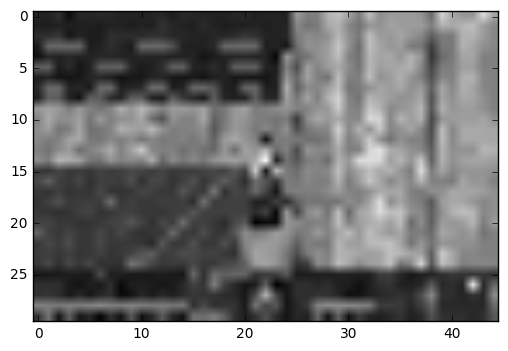

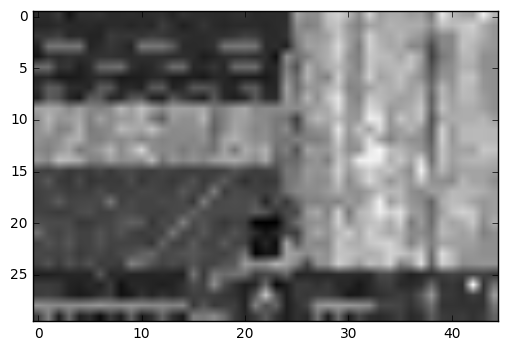

In [26]:
j = 0
test_img0 = riffled[j*2, :, :, :]
test_img1 = riffled[j*2+1, :, : :]

plt.imshow(test_img0[:, :, 0], cmap="gray")
plt.show()
plt.imshow(test_img1[:, :, 0], cmap="gray")
plt.show()


In [23]:
def get_vizdoom_slowness(prediction):
    slow_features = prediction.shape[1]
    slowness = np.zeros(slow_features)
    for i in range(slow_features):
        for j in range(int(prediction.shape[0]/2)):
            slowness[i] += abs(prediction[j*2, i] - prediction[j*2+1, i] )
        slowness[i] = slowness[i] / float(prediction.shape[0])
    return slowness

In [39]:
prediction = net.predict(riffled)
print(prediction.shape)
print(get_vizdoom_slowness(prediction))

(6400, 3)
[ 0.166  0.221  0.214]


In [30]:
np.set_printoptions(precision=3, suppress=True)
print(prediction[0:10])
print(average_delta(prediction[0,:]))

[[-0.257  2.385 -0.618  0.36   1.378 -0.8   -0.277]
 [ 0.175  2.203 -1.294  1.017  1.806  0.76   0.028]
 [ 0.119  0.66   1.074 -1.799  0.121  0.747  0.752]
 [ 0.332 -0.043  0.924 -0.13  -0.063  1.813 -0.822]
 [-0.491  1.291 -0.606  0.07  -1.379 -1.954  0.839]
 [-0.062  2.369 -0.85   0.442  1.505 -0.273  0.675]
 [-0.687 -0.472  0.923 -0.56   0.526 -1.094  1.345]
 [-0.49  -0.73   0.62  -0.801  1.203  2.725  2.2  ]
 [ 1.247 -0.726  0.513  2.272 -0.263 -0.035 -0.575]
 [ 0.788  0.115  0.57   0.856 -0.581  0.211 -0.406]]


IndexError: tuple index out of range

In [ ]:
j = 3

test_img0 = riffled[j*2, :, :, :]
test_img1 = riffled[j*2+1, :, : :]

plt.imshow(test_img0[:, :, 0], cmap="gray")
plt.show()
prediction = net.predict(riffled)
plt.imshow(test_img1[:, :, 0], cmap="gray")
plt.show()